In [1]:
import sys
import datetime as dt
sys.path.append('../..')
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from rivapy.instruments import SimpleSchedule, PPASpecification, GreenPPASpecification
from rivapy.tools.datetime_grid import DateTimeGrid, MonthlyConstantFunction, HourlyConstantFunction
from rivapy.marketdata import PowerPriceForwardCurve
from rivapy.models import OrnsteinUhlenbeck
import rivapy.models.residual_demand_model as rdm

%load_ext autoreload
%autoreload 2

%matplotlib inline

C:\Users\doeltz\development\RiVaPy\notebooks\instruments\../..\rivapy\__init__.py:8: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


# Green PPA Specification

In [8]:
simple_schedule = SimpleSchedule(dt.datetime(2022,12,1), dt.datetime(2023,12,1,4,0,0), freq='1H')
values = np.ones((len(simple_schedule.get_schedule()),))
hpfc = PowerPriceForwardCurve( dt.datetime(2022,12,1), dt.datetime(2022,12,1), dt.datetime(2023,12,1,4,0,0), freq='1H', values = values)
#simple_schedule = SimpleSchedule(dt.datetime(2022,12,1), dt.datetime(2023,1,1,4,0,0), freq='1H')
#hpfc.value(dt.datetime(2022,1,1), simple_schedule)

In [3]:
ppa = PPASpecification(20.0, simple_schedule, fixed_price = 10.0)
green_ppa = GreenPPASpecification(simple_schedule, fixed_price = 10.0, technology = 'wind_offshore')

In [4]:
forecast_amount = np.ones((len(simple_schedule.get_schedule()),))

In [5]:
green_ppa.compute_flows(dt.datetime(2022,12,1), hpfc, forecast_amount)

,index,amount,flow
dates,,,
2022-12-01 00:00:00,0,1.0,-9.0
2022-12-01 01:00:00,1,1.0,-9.0
2022-12-01 02:00:00,2,1.0,-9.0
2022-12-01 03:00:00,3,1.0,-9.0
2022-12-01 04:00:00,4,1.0,-9.0
...,...,...,...
2023-11-30 23:00:00,8759,1.0,-9.0
2023-12-01 00:00:00,8760,1.0,-9.0
2023-12-01 01:00:00,8761,1.0,-9.0


In [3]:
import sklearn.gaussian_process as gp

In [91]:
30*24

720

In [92]:
x = np.linspace(0,1,30*24)
y = np.zeros(x.shape)
kernel = gp.kernels.ConstantKernel(1.0, constant_value_bounds="fixed") * gp.kernels.RBF(0.01, length_scale_bounds="fixed")
reg = gp.GaussianProcessRegressor(kernel=kernel,random_state=0, alpha=0.2).fit(x.reshape(-1, 1), y)

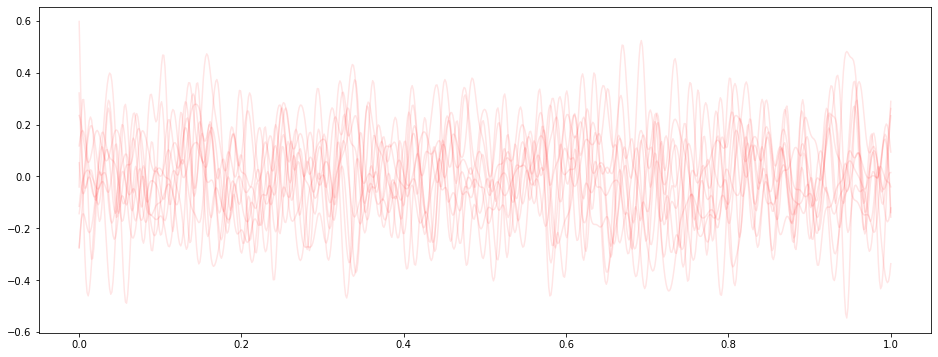

In [93]:
plt.figure(figsize=(16,6))
y_samples = reg.sample_y(x.reshape(-1, 1), n_samples=10)
for i in range(y_samples.shape[1]):
    plt.plot(x,y_samples[:,i],'-r',alpha=0.1)

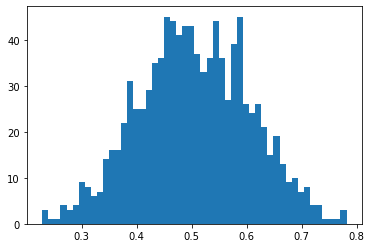

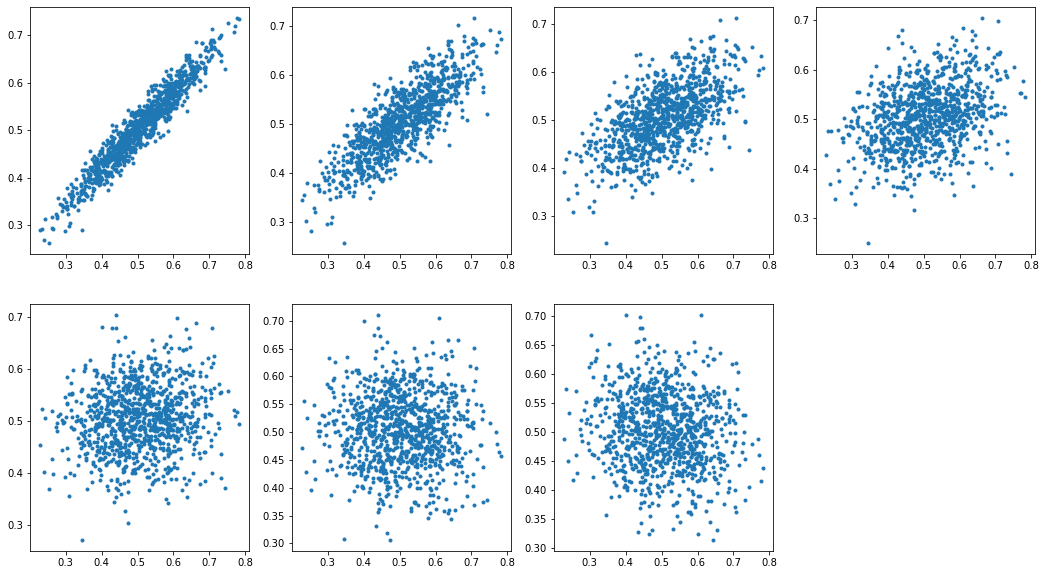

In [94]:
y = reg.sample_y(x.reshape(-1, 1), n_samples=1000, random_state=42)#.reshape((-1,))
from scipy.stats import norm, beta
sim = beta.ppf(norm.cdf(y), 1.0, 1.0)#norm.cdf(y))
#plt.plot(sim)
plt.hist(sim[0,:], bins=50);
plt.figure(figsize=(18,10))
for i in range(1,8):
    plt.subplot(2,4,i)
    plt.plot(sim[0,:],sim[i,:],'.')

# Residual Demand Model

In [17]:
tg = DateTimeGrid(simple_schedule.start, simple_schedule.end, freq='1H')

../..\rivapy\tools\datetime_grid.py:16: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  self.timegrid = np.array([(d-self.start).total_seconds()/pd.Timedelta('1Y').total_seconds() for d in self.dates])


## Wind model

In [49]:
def mean_level(a,b,c):
    def _mean_level(t):
        return a*np.cos(2.0*np.pi*t + b)+c
    return _mean_level

wind_model = rdm.WindPowerModel(speed_of_mean_reversion=91.151, volatility=15.155, 
                                 mean_level=lambda t: 0.311*np.cos(2.0*np.pi*t + 0.002)+-1.999)

In [50]:
n_sims = 5000
wind_rnd = np.random.normal(size=(n_sims, tg.shape[0]-1))
wind_efficiency = wind_model.simulate(tg, 0.5, wind_rnd)

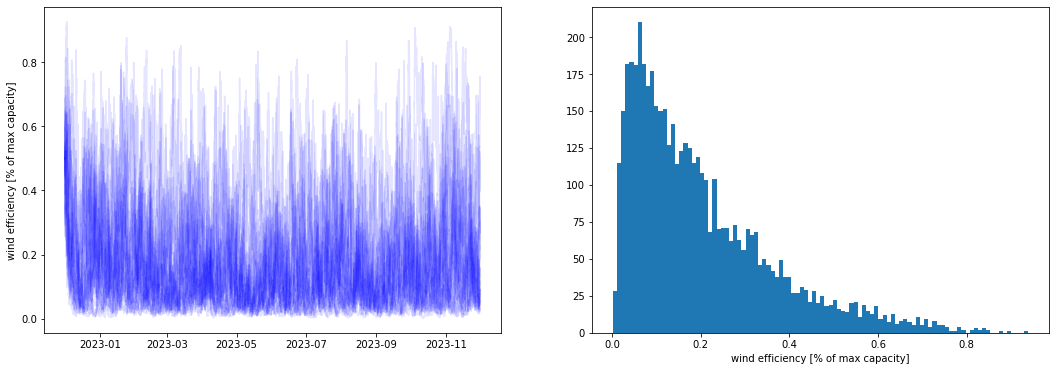

In [51]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
for i in range(20):
    plt.plot(tg.dates,wind_efficiency[:,i], '-b', alpha=0.1)
plt.ylabel('wind efficiency [% of max capacity]')
plt.subplot(1,2,2)
plt.xlabel('wind efficiency [% of max capacity]')
plt.hist(wind_efficiency[-1,:], bins=100);

## Solar model

### Solar profile

In [11]:
_monthly_solar_profile = np.zeros((12,25))
_monthly_solar_profile[0][9:16] = 1.0
_monthly_solar_profile[1][9:16] = 1.0
_monthly_solar_profile[2][8:16] = 1.0
_monthly_solar_profile[3][8:17] = 1.0
_monthly_solar_profile[4][8:18] = 1.0
_monthly_solar_profile[5][7:19] = 1.0
_monthly_solar_profile[6][6:20] = 1.0
_monthly_solar_profile[7][6:20] = 1.0
_monthly_solar_profile[8][7:19] = 1.0
_monthly_solar_profile[9][8:18] = 1.0
_monthly_solar_profile[10][9:16] = 1.0
_monthly_solar_profile[11][9:16] = 1.0
def __monthly_solar_profile(d):
    return _monthly_solar_profile[d.month-1, d.hour]
solar_profile = rdm.SolarProfile(__monthly_solar_profile)
profile = solar_profile.get_profile(tg)

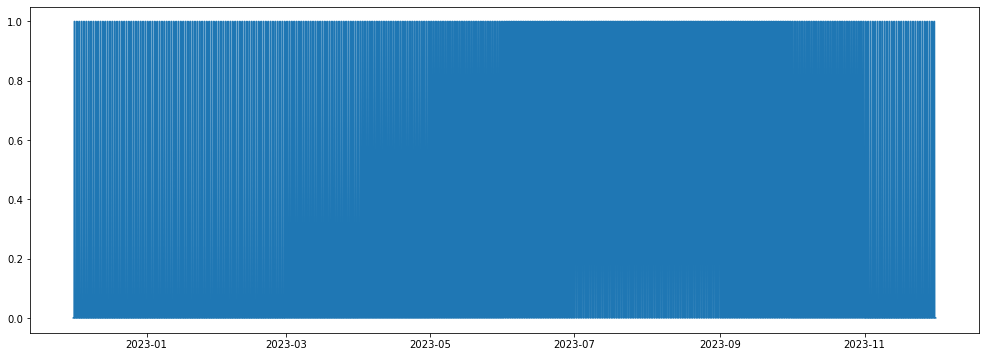

In [110]:
plt.figure(figsize=(17,6))
plt.plot(tg.dates, profile);

### Simulated values

In [14]:
def mean_level(a1,b1,a2,b2,c):
    def _mean_level(t):
        return a1*np.cos(2.0*np.pi*t.timegrid + b1)+a2*np.cos(4.0*np.pi*t.timegrid + b2)+c
    return _mean_level
daily_solar_model = OrnsteinUhlenbeck(speed_of_mean_reversion = 261.817, volatility=16.087)
solar_model = rdm.SolarModel(daily_solar_model, solar_profile, mean_level(-1.23,0.476,-0.614,0.093,-0.798))    

In [18]:
solar_rnd = np.random.normal(size=(100, tg.get_daily_subgrid().shape[0]-1))
solar = solar_model.simulate(tg, 0.5, solar_rnd)

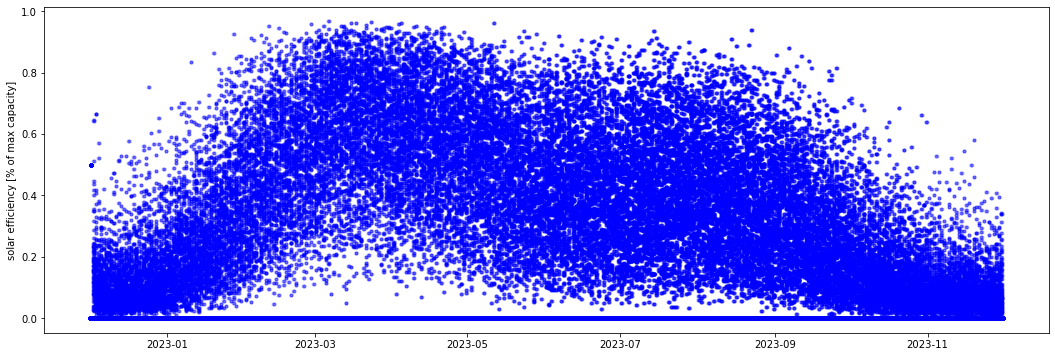

In [26]:
plt.figure(figsize=(18,6))
for i in range(100):
    plt.plot(tg.dates, solar[:,i], '.b', alpha=0.1)
plt.ylabel('solar efficiency [% of max capacity]');

## Supplycurve

In [27]:
supply = rdm.SupplyFunction(floor=(10,-3000), cap=(85,3000), peak=(39.425, 528.343), 
                           offpeak=(43.0,-713.804, 0.491), peak_hours=set([8,9,10,11,12,13,14,15,16,17,18]))

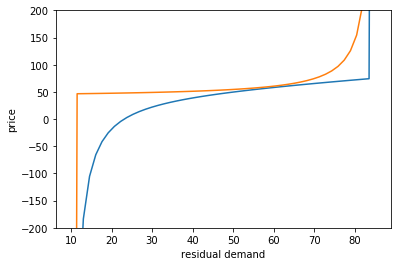

In [29]:
supply.plot(dt.datetime(2020,1,1,0,0))
supply.plot(dt.datetime(2020,1,1,10,0))
plt.ylim(-200,200);

## Load

The demand model may provide negative values. One may use a log-demand model to circumvent this. Howevere, since seasonal pattern is much higher than the stochastic fluctuations, the probability for negative load is very low.

In [32]:
profile = MonthlyConstantFunction(values=[0.7, 0.8, 0.9, 1.0, 1.1,1.0,0.9,0.8, 0.7, 0.6,0.6,0.6,0.6])*HourlyConstantFunction(values=[1]*24)
daily_model = OrnsteinUhlenbeck(speed_of_mean_reversion = 261.817, volatility=16.087)
demand_model = rdm.LoadModel(daily_model, profile)

In [34]:
demand_rnd = np.random.normal(size=(100, tg.shape[0]-1))
demand_sim = demand_model.simulate(tg, 0.5, demand_rnd)

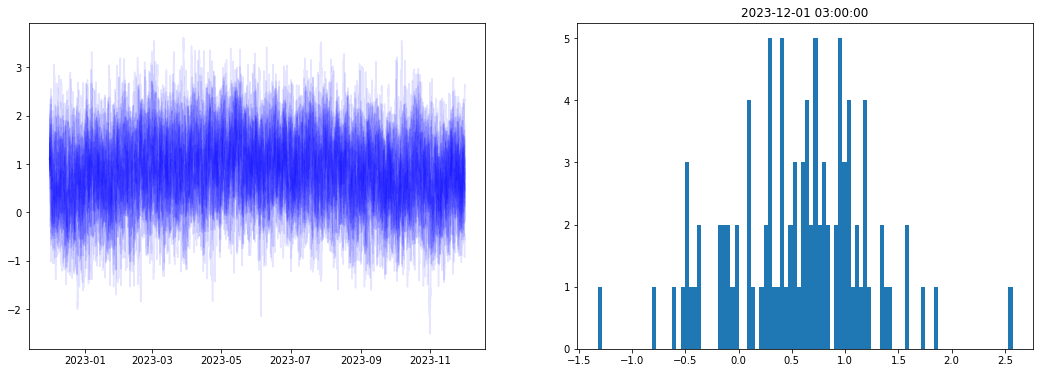

In [36]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
for i in range(20):
    plt.plot(tg.dates, demand_sim[:,i], '-b', alpha=0.1)
plt.subplot(1,2,2)
plt.title(tg.dates[-1])
plt.hist(demand_sim[-1,:], bins=100);

## Power prices and residual demand

In [56]:
residual_model = rdm.ResidualDemandModel(wind_model, solar_model, demand_model, supply)
#residual_simulated = residual_model.simulate(tg, 0.5, wind_rnd, 0.5, solar_rnd, 0.5, demand_rnd)

In [57]:
n_sims = 100
results = residual_model.simulate(tg, 0.5, 0.5, 0.5, n_sims = n_sims)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()